In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import set_style
from datetime import datetime, timedelta

In [2]:
raw = pd.read_csv("sp500.csv")
raw = raw.iloc[::-1].reset_index(drop=True)

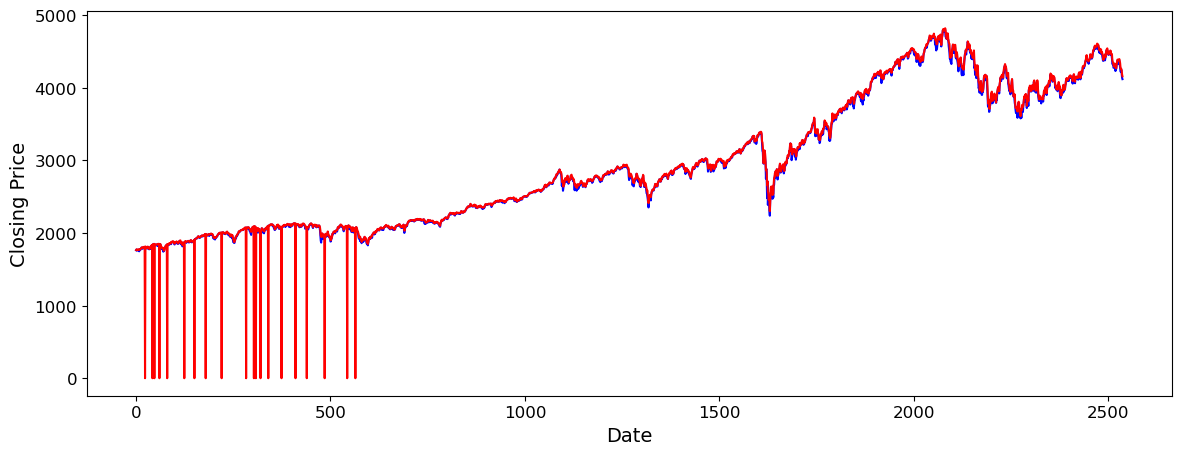

In [3]:
plt.figure(figsize=(14,5))

plt.plot(raw['Close/Last'], color='blue', label='close')
plt.plot(raw['High'], color='red', label='open')


plt.xlabel("Date", fontsize=14)
plt.ylabel("Closing Price", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [4]:
data=raw[raw["High"]!=0].reset_index(drop=True)

data.rename(columns={'Close/Last': 'Close'}, inplace=True)

data['Date'] = pd.to_datetime(data['Date'])

data['HiLo']=data['High']-data['Low']

data['OpCl']= data['Close'] - data['Open']

data['overnight']=data['Open']-data['Close'].shift(1)

In [5]:
data

,Date,Close,Open,High,Low,HiLo,OpCl,overnight
0,2013-10-28,1762.11,1759.42,1764.99,1757.67,7.32,2.69,NaN
1,2013-10-29,1771.95,1762.93,1772.09,1762.93,9.16,9.02,0.82
2,2013-10-30,1763.31,1772.27,1775.22,1757.24,17.98,-8.96,0.32
3,2013-10-31,1756.54,1763.24,1768.53,1755.72,12.81,-6.70,-0.07
4,2013-11-01,1761.64,1758.70,1765.67,1752.70,12.97,2.94,2.16
...,...,...,...,...,...,...,...,...
2513,2023-10-23,4217.04,4210.40,4255.84,4189.22,66.62,6.64,-13.76
2514,2023-10-24,4247.68,4235.79,4259.38,4219.43,39.95,11.89,18.75
2515,2023-10-25,4186.77,4232.42,4232.42,4181.42,51.00,-45.65,-15.26
2516,2023-10-26,4137.23,4175.99,4183.60,4127.90,55.70,-38.76,-10.78


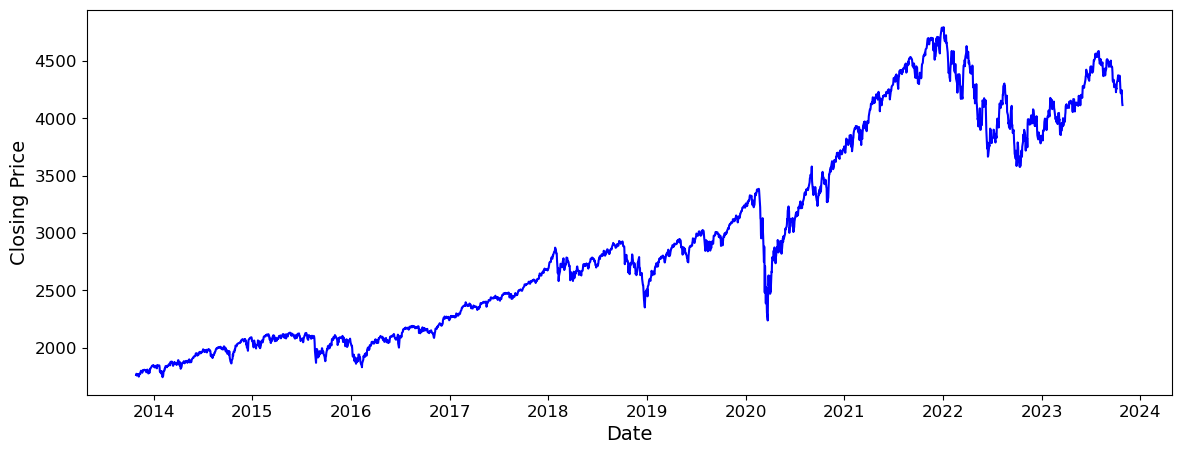

In [6]:
plt.figure(figsize=(14,5))

plt.plot(data['Date'],data['Close'], color='blue', label='close')

plt.xlabel("Date", fontsize=14)
plt.ylabel("Closing Price", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [14]:
#######################################################################################################
#######################################################################################################

In [15]:
################################# Models; data seem to have a trent ###################################

In [7]:
# Split the data into training set and test set
testsize = 14


data_train = data.iloc[:-testsize].copy()
data_test = data.iloc[-testsize:].copy()

##### The average forecast

In [8]:
# Close
train_close_avg = data_train.Close.mean()

# OpCl
train_OpCl_avg = data_train.OpCl.mean()

#### The naive forecast

In [9]:
#Close
naive_close = data_train.Close.values[-1]
#OpCl
naive_OpCl = data_train.OpCl.values[-1]

##### The trend forecast

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
slr1 = LinearRegression()
slr2 = LinearRegression()

#Close
slr1.fit(np.arange(1, len(data_train) + 1).reshape(-1,1),
        data_train.Close)

future_predicion_days=10

trend_close_pred = slr1.predict(np.arange(len(data_train)+1, len(data_test) + len(data_train)+1+future_predicion_days).reshape(-1,1))

#OpCl
slr2.fit(np.arange(1, len(data_train) + 1).reshape(-1,1),
        data_train.OpCl)

trend_OpCl_pred = slr2.predict(np.arange(len(data_train)+1, len(data_test) + len(data_train) + 1+future_predicion_days).reshape(-1,1))

##### Random walk with drift forecast

In [50]:
# Close
beta_hat_1 = data_train.Close.diff().mean()

drift_pred_1 = data_train.Close.values[-1] + beta_hat_1*np.arange(1,len(data_test) + 1)

#OpCl
beta_hat_2 = data_train.OpCl.diff().mean()

drift_pred_2 = data_train.OpCl.values[-1] + beta_hat_2*np.arange(1,len(data_test) + 1)

In [ ]:
############################################################################################################
###########################################################################################################

#### moving average 

In [14]:
window_size_cl = 2   ### found it in Analysis-Copy4

#Close
moving_average_close = data_train['Close'].rolling(window=window_size_cl).mean()

In [15]:
window_size_OpCl = 30   ### found it in Analysis-Copy4

#OpCl
moving_average_OpCl = data_train['OpCl'].rolling(window=window_size_OpCl).mean()

#### Double exponential smoothing

In [16]:
from statsmodels.tsa.holtwinters import Holt

In [17]:
import pickle

In [18]:
# Load the saved results
with open('exp_rmses_close.pkl', 'rb') as f:
    exp_rmses_close = pickle.load(f)

with open('exp_rmses_OpCl.pkl', 'rb') as f:
    exp_rmses_OpCl = pickle.load(f)

In [19]:
## Cl

exp_ind_close = np.unravel_index(np.argmin(np.mean(exp_rmses_close, axis=0), axis=None), 
                           np.mean(exp_rmses_close, axis=0).shape)
np.unravel_index(np.argmin(np.mean(exp_rmses_close, axis=0), axis=None), 
                 np.mean(exp_rmses_close, axis=0).shape)



print("The alpha and beta values that give a double exponential",
         "smoothing model with lowest avg cv rmse are",
         "alpha = ", np.arange(0, 0.2, .01)[exp_ind_close[0]],
         "and beta = ", np.arange(0, 0.2, .01)[exp_ind_close[1]])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_rmses_close, axis=0)[exp_ind_close],3))

The alpha and beta values that give a double exponential smoothing model with lowest avg cv rmse are alpha =  0.04 and beta =  0.15
This model had an avg cv rmse of 46.426


In [35]:
# Fit the Holt model with the optimal alpha and beta on the entire training dataset
exp_smooth_close = Holt(data_train.Close.values).fit(smoothing_level=np.arange(0, 0.2, .01)[exp_ind_close[0]], 
                                                     smoothing_trend=np.arange(0, 0.2, .01)[exp_ind_close[1]],
                                                     optimized=False)


In [36]:
### OpCl

exp_ind_OpCl = np.unravel_index(np.argmin(np.mean(exp_rmses_OpCl, axis=0), axis=None), 
                           np.mean(exp_rmses_OpCl, axis=0).shape)
np.unravel_index(np.argmin(np.mean(exp_rmses_OpCl, axis=0), axis=None), 
                 np.mean(exp_rmses_OpCl, axis=0).shape)

print("The alpha and beta values that give a double exponential",
         "smoothing model with lowest avg cv rmse are",
         "alpha = ", np.arange(0, 0.2, .01)[exp_ind_OpCl[0]],
         "and beta = ", np.arange(0, 0.2, .01)[exp_ind_OpCl[1]])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_rmses_OpCl, axis=0)[exp_ind_OpCl],3))

The alpha and beta values that give a double exponential smoothing model with lowest avg cv rmse are alpha =  0.01 and beta =  0.15
This model had an avg cv rmse of 28.619


In [37]:
exp_smooth_OpCl = Holt(data_train.OpCl.values).fit(smoothing_level=np.arange(0, 0.2, .01)[exp_ind_OpCl[0]], 
                                                     smoothing_trend=np.arange(0, 0.2, .01)[exp_ind_OpCl[1]],
                                                     optimized=False)

#### ARIMA

In [29]:
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX

In [54]:
# Load the saved results
with open('arima_rmses_close.pkl', 'rb') as f:
    arima_rmses = pickle.load(f)

with open('arima_rmses_OpCl.pkl', 'rb') as f:
    arima_rmses_OpCl = pickle.load(f)

In [55]:
arima_ind_close = np.unravel_index(np.argmin(np.mean(arima_rmses, axis=0), axis=None), 
                             np.mean(arima_rmses, axis=0).shape)
np.unravel_index(np.argmin(np.mean(arima_rmses, axis=0), axis=None), 
                 np.mean(arima_rmses, axis=0).shape)

(0, 0)

In [56]:
print("The p and q values that give an ARIMA model",
         "with lowest avg cv mse are",
         "p = ", range(4)[arima_ind_close[0]],
         "and q = ", range(4)[arima_ind_close[1]])

print("This model had an avg cv mse of",
         np.round(np.mean(arima_rmses, axis=0)[arima_ind_close],3))

The p and q values that give an ARIMA model with lowest avg cv mse are p =  0 and q =  0
This model had an avg cv mse of 39.172


In [57]:
arima = SARIMAX(data.Close.values,  order=(range(4)[arima_ind_close[0]], 1, range(4)[arima_ind_close[1]])).fit(maxiter=500)

In [58]:
## OpCl
arima_ind_OpCl = np.unravel_index(np.argmin(np.mean(arima_rmses_OpCl, axis=0), axis=None), 
                             np.mean(arima_rmses_OpCl, axis=0).shape)
np.unravel_index(np.argmin(np.mean(arima_rmses_OpCl, axis=0), axis=None), 
                 np.mean(arima_rmses_OpCl, axis=0).shape)

print("The p and q values that give an ARIMA model",
         "with lowest avg cv mse are",
         "p = ", range(4)[arima_ind_OpCl[0]],
         "and q = ", range(4)[arima_ind_OpCl[1]])

print("This model had an avg cv mse of",
         np.round(np.mean(arima_rmses_OpCl, axis=0)[arima_ind_OpCl],3))

The p and q values that give an ARIMA model with lowest avg cv mse are p =  3 and q =  1
This model had an avg cv mse of 28.429


In [59]:
arima_OpCl = SARIMAX(data.OpCl.values,  order=(range(4)[arima_ind_OpCl[0]], 1, range(4)[arima_ind_OpCl[1]])).fit(maxiter=500)

In [62]:
# Calculate the average cross-validation root mean squared error for these models. 
# Set up this cross-validation so that there are ten splits and each holdout set only has three observations in it.

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [83]:
mses_cl = np.zeros((5,10))   # 5 is the number of models, 10 is the number of splits

mses_OpCl = np.zeros((5,10))

kfold = TimeSeriesSplit(10, 
                     test_size=3)

In [84]:
j = 0  # counter for the kfold split

for train_index, test_index in kfold.split(data_train):
    data_tt = data_train.loc[train_index]
    data_ho = data_train.loc[test_index]

        
    ############## average ##############  
        #Close
    tt_close_avg = data_tt.Close.mean()
    
    mses_cl[0,j] = np.sqrt(mean_squared_error(data_ho.Close,
                                    tt_close_avg*np.ones(3)))
        #OpCl
    tt_OpCl_avg = data_train.OpCl.mean()
    
    mses_OpCl[0,j] = np.sqrt(mean_squared_error(data_ho.OpCl,
                                    tt_OpCl_avg*np.ones(3)))
        
    
    ############### naive ###############
         #Close
    tt_naive_close = data_tt.Close.values[-1]
    
    mses_cl[1,j] = np.sqrt(mean_squared_error(data_ho.Close.values,
                                    tt_naive_close*np.ones(3)))
        #OpCl
    tt_naive_OpCl = data_tt.OpCl.values[-1]
    
    mses_OpCl[1,j] = np.sqrt(mean_squared_error(data_ho.OpCl.values,
                                    tt_naive_OpCl*np.ones(3)))
    
    
    ############## trend ###############
    
    slr1 = LinearRegression()
    slr2 = LinearRegression()
        
        #Close
    slr1.fit(np.arange(1, len(data_tt) + 1).reshape(-1,1),
              data_tt.Close)
    tt_close_pred = slr1.predict(np.arange(len(data_tt)+1, len(data_tt) + len(data_ho) + 1).reshape(-1,1))
    
    mses_cl[2,j] = np.sqrt(mean_squared_error(data_ho.Close.values,
                                             tt_close_pred))

        #OpCl
    slr2.fit(np.arange(1, len(data_tt) + 1).reshape(-1,1),
              data_tt.OpCl)
    tt_OpCl_pred = slr2.predict(np.arange(len(data_tt)+1, len(data_tt) + len(data_ho) + 1).reshape(-1,1))
    
    mses_OpCl[2,j] = np.sqrt(mean_squared_error(data_ho.OpCl.values,
                                             tt_OpCl_pred))

    ################## drift ############
    
       # Close
    beta_hat_1 = data_tt.Close.diff().mean()
    drift_pred_1 = data_tt.Close.values[-1] + beta_hat_1*np.arange(1,len(data_ho) + 1)
    mses_cl[3,j] = np.sqrt(mean_squared_error(data_ho.Close.values,
                                             drift_pred_1))

       #OpCl
    beta_hat_2 = data_tt.OpCl.diff().mean()
    drift_pred_2 = data_tt.OpCl.values[-1] + beta_hat_2*np.arange(1,len(data_ho) + 1)
    mses_OpCl[3,j] = np.sqrt(mean_squared_error(data_ho.OpCl.values,
                                             drift_pred_2))
    
    
     # Calculate the MOVING AVERAGE for 'Close'
    tt_close_moving_avg = data_tt['Close'].rolling(window=window_size_cl).mean().values[-1]

    # Calculate the MOVING AVERAGE for 'OpCl'
    tt_OpCl_moving_avg = data_tt['OpCl'].rolling(window=window_size_OpCl).mean().values[-1]

    # Calculate RMSE for 'Close'
    mses_cl[4, j] = np.sqrt(mean_squared_error(data_ho['Close'].values, tt_close_moving_avg * np.ones(len(data_ho))))

    # Calculate RMSE for 'OpCl'
    mses_OpCl[4, j] = np.sqrt(mean_squared_error(data_ho['OpCl'].values, tt_OpCl_moving_avg * np.ones(len(data_ho))))
    
    j +=1
# Append the results for the moving average method to mses_cl and mses_OpCl
# mses_cl = np.vstack((mses_cl, ma_cl))
# mses_OpCl = np.vstack((mses_OpCl, ma_OpCl))

In [85]:
##_avg kfold mse_cl?
np.mean(mses_cl, axis=1)    # mses_cl is 5x10

array([1453.08140388,   39.17205524,  100.08079495,   39.50108165,
         46.35457359])

In [86]:
## avg kfold mse_OpCl?
np.mean(mses_OpCl, axis=1)

array([28.50327202, 33.20637047, 28.55736862, 33.21521007, 28.47974741])

In [74]:
# Rmse so far: average, naive, trend, drift, moving average, double exponential,ARIMA
# for Close

result_close = np.append( np.mean((mses_cl), axis=1), (np.round(np.mean(exp_rmses_close, axis=0)[exp_ind_close],3)) )
result_close = np.append(result_close,( np.round(np.mean(arima_rmses, axis=0)[arima_ind_close],3)) )
result_close

array([1453.08140388,   39.17205524,  100.08079495,   39.50108165,
         46.35457359,   46.426     ,   39.172     ])

In [93]:
# Rmse so far: average, naive, trend, drift, moving average, double exponential, ARIMA
# for OpCl

result_OpCl = np.append( np.mean((mses_OpCl), axis=1), (np.mean(exp_rmses_OpCl, axis=0)[exp_ind_OpCl]))
result_OpCl = np.append( result_OpCl,  np.round(np.mean(arima_rmses_OpCl, axis=0)[arima_ind_OpCl],3)   )
result_OpCl

array([28.50327202, 33.20637047, 28.55736862, 33.21521007, 28.47974741,
       28.61913526, 28.429     ])

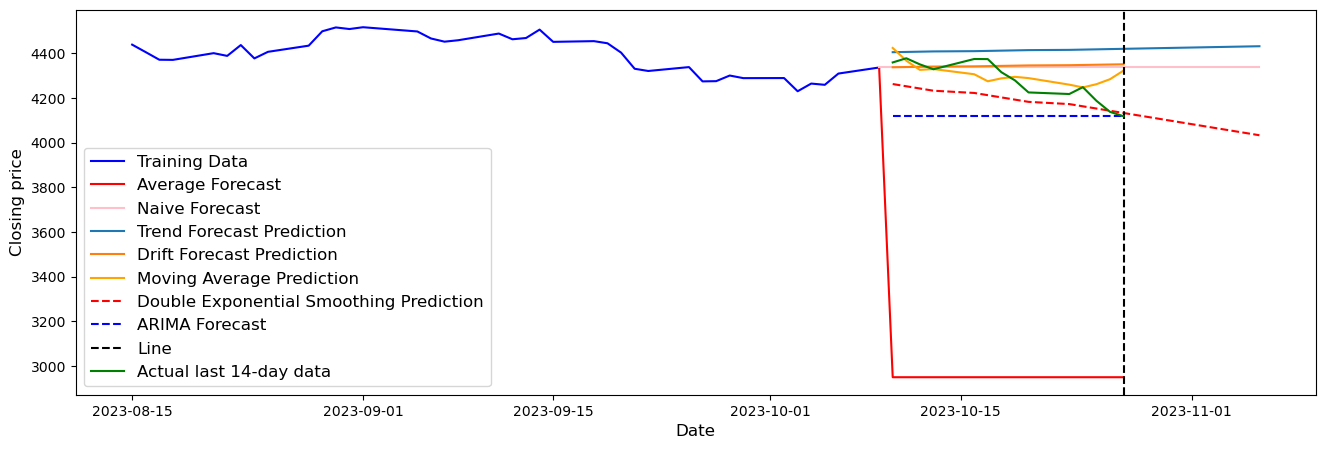

In [60]:
######### Close : all models together

# need to rerun the command for the drift:


plt.figure(figsize=(16,5))

# plt.plot(data_train.Date, data_train.Close, label="Training Data")

filtered_data = data_train[data_train['Date'] >= '2023-08-15']

plt.plot(filtered_data['Date'], 
         filtered_data['Close'],
            color='blue',
           # '-o',
            label = "Training Data")


# Find the last date in the training data
last_training_date = data_train.Date.iloc[-1]

########### Average forecast

# Plot the "testsize"-day average forecast using a line and connect it to the last training data point
plt.plot([last_training_date] + data_test.Date.tolist(), 
         [data_train.Close.iloc[-1]] + [train_close_avg] * testsize, 
         color='red', 
         #linestyle='--', 
         label="Average Forecast")

# plt.scatter(data_test.Date,
#             train_close_avg*np.ones(testsize),
#             marker='x',
#             s=150,
#             color='red',
#             label="Average Forecast")


########### Naive forecast
additional_dates = [data['Date'].iloc[-1] + timedelta(days=i) for i in range(1, 11)]

plt.plot([last_training_date] + data_test.Date.tolist()  + additional_dates, 
         [data_train.Close.iloc[-1]] + [naive_close] * (testsize+10), 
         color='pink', 
         #linestyle='--', 
         label="Naive Forecast")

########### Trend forecast
plt.plot(data_test.Date.tolist()  + additional_dates,
            trend_close_pred,
            #'r--',
            label="Trend Forecast Prediction")

############ drift forecast

plt.plot(data_test.Date,
            drift_pred_1,
            #'r--',
            label="Drift Forecast Prediction")

############ moving average
plt.plot(data_test.Date, moving_average_close[-testsize:], color='orange', label="Moving Average Prediction")

########### double exponential ############
plt.plot(data_test.Date.tolist()  + additional_dates, 
         exp_smooth_close.forecast(testsize+future_predicion_days),
         'r--',
         label="Double Exponential Smoothing Prediction")

################# arima ###################
plt.plot(data_test.Date, 
         arima.forecast(testsize),
         'b--',
         label="ARIMA Forecast")

plt.axvline(x = data_test.Date.iloc[-1], 
         color = 'black',  linestyle = '--', label="Line")

# plot the actual data of the last testsize days
plt.plot(data_test.Date, data_test.Close, color='green', label="Actual last "+str(testsize)+"-day data")

plt.legend(fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Closing price", fontsize=12)

#plt.ylim(4000,4400)

# plt.title("Average forecast", fontsize=14)

    
plt.show()

<Figure size 1000x500 with 0 Axes>

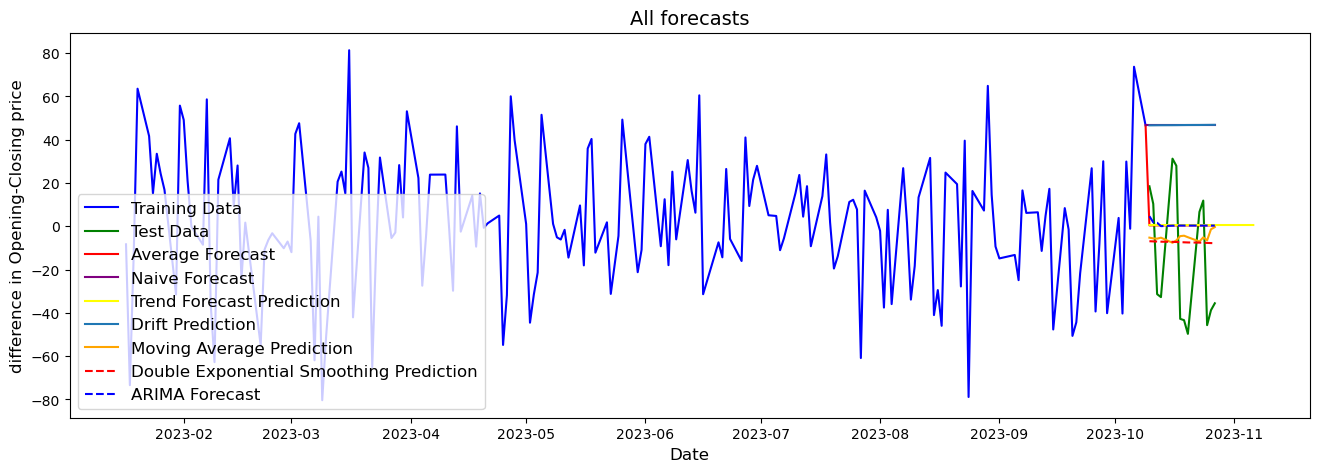

In [61]:
#### OpCl: all models together

plt.figure(figsize=(10,5))

plt.figure(figsize=(16,5))

filtered_data = data_train[data_train['Date'] >= '2023-01-15']

plt.plot(filtered_data['Date'], 
         filtered_data['OpCl'],
           color = 'blue',#'-o',
            label = "Training Data")

plt.plot(data_test.Date,
            data_test.OpCl,
            color = 'green',
            label="Test Data")


############## average ####################
plt.plot([last_training_date] + data_test.Date.tolist(), 
         [data_train.OpCl.iloc[-1]] + [train_OpCl_avg] * testsize, 
         color='red', 
         #linestyle='--', 
         label="Average Forecast")



############# naive #######################
plt.plot([last_training_date] + data_test.Date.tolist(), 
         [data_train.OpCl.iloc[-1]] + [naive_OpCl] * testsize, 
         color='purple', 
         #linestyle='--', 
         label="Naive Forecast")



############### trend ######################
plt.plot(data_test.Date.tolist()  + additional_dates,
            trend_OpCl_pred, color = 'yellow',
            #'r--',
            label="Trend Forecast Prediction")

############## drift ######################
plt.plot(data_test.Date,
            drift_pred_2,
            #'r--',
            label="Drift Prediction")

############ moving average ################
plt.plot(data_test.Date, moving_average_OpCl[-testsize:], color='orange', label="Moving Average Prediction")


########### double exponential ############
plt.plot(data_test.Date, 
         exp_smooth_OpCl.forecast(testsize),
         'r--',
         label="Double Exponential Smoothing Prediction")


################ arima ###################
plt.plot(data_test.Date, 
         arima_OpCl.forecast(testsize),
         'b--',
         label="ARIMA Forecast")





plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Date", fontsize=12)
plt.ylabel("difference in Opening-Closing price", fontsize=12)

plt.title("All forecasts", fontsize=14)

plt.legend(fontsize=12)
    
plt.show()

In [95]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [96]:
X=data[['Open', 'High', 'Low']]
y1 = data['Close']
y2 = data['OpCl']

In [97]:
# Use TimeSeriesSplit for time-based splitting
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

for train_index, test_index in tscv.split(X):
    X_train1, X_test1 = X.iloc[train_index], X.iloc[test_index]
    y_train1, y_test1 = y1.iloc[train_index], y1.iloc[test_index]

    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y2.iloc[train_index], y2.iloc[test_index]

# Initialize the Gradient Boosting Regressor
gb_model1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)

# Train the model
gb_model1.fit(X_train1, y_train1)

# Make predictions on the test set
y1_pred = gb_model1.predict(X_test1)

# Evaluate the model
mse = mean_squared_error(y_test1, y1_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")
###################################################################################################
# Initialize the Gradient Boosting Regressor
gb_model2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)

# Train the model
gb_model2.fit(X_train2, y_train2)

# Make predictions on the test set
y2_pred = gb_model2.predict(X_test2)

# Evaluate the model
mse2 = mean_squared_error(y_test2, y2_pred)
rmse2 = np.sqrt(mse2)

print(f"Root Mean Squared Error (RMSE): {rmse2}")


Root Mean Squared Error (RMSE): 28.459416716528988
Root Mean Squared Error (RMSE): 40.0010576483645


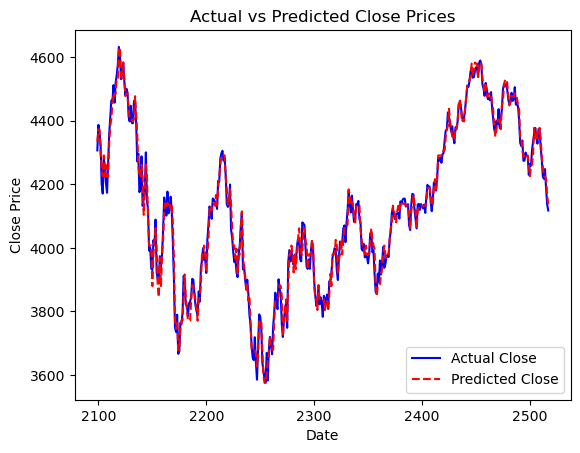

In [98]:
# Plot actual Close values
plt.plot(y_test1.index, y_test1, label='Actual Close', color='blue')

# Plot predicted Close values
plt.plot(y_test1.index, y1_pred, label='Predicted Close', color='red', linestyle='dashed')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()

# Show the plot
plt.show()
# Make sure to adjust the color, linestyle, and other parameters as needed for your visualization preferences. You can do the same for the other target (OpCl) by replacing the relevant variables (y_test2, y2_pred).

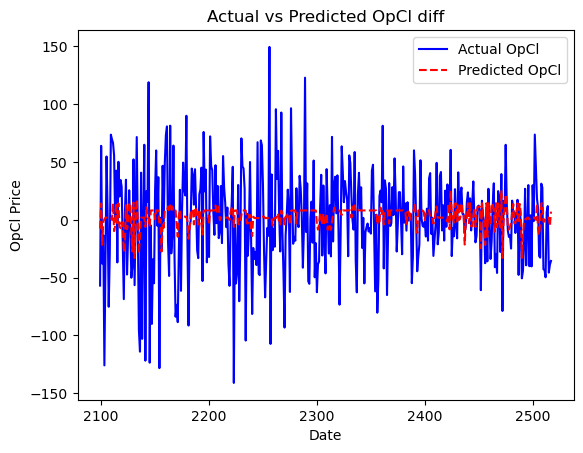

In [100]:
# Plot actual Close values
plt.plot(y_test2.index, y_test2, label='Actual OpCl', color='blue')

# Plot predicted Close values
plt.plot(y_test2.index, y2_pred, label='Predicted OpCl', color='red', linestyle='dashed')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('OpCl Price')
plt.title('Actual vs Predicted OpCl diff')
plt.legend()

# Show the plot
plt.show()

In [ ]:
## I am going to use the double exponential for the closing price and ARIMA for the dependence between closing-opening.

In [76]:
# Extend Your Date Range

last_date = data['Date'].iloc[-1]
next_date = last_date + pd.DateOffset(days=1)  # Add one day to the last date
date_range = pd.date_range(start=last_date, end=next_date)

In [ ]:
# Create a DataFrame with Extended Date Range
pred_data = pd.DataFrame({'Date': date_range, 'Close': [np.nan] * len(date_range), 'OpCl': [np.nan] * len(date_range)}) 
new_data = pd.DataFrame([data.iloc[-1]], columns=['Date', 'Close', 'OpCl'])
pred_data.iloc[0] = new_data.iloc[-1]
pred_data

In [ ]:
# Make Predictions for the Next Day:

###  to fit, I used data  (and not only data_train) because I was satisfied with the model on the data_train.

exp_ind_close =(11,15)

exp_smooth_close = Holt(data.Close.values).fit(smoothing_level= exp_ind_close[0]/100, 
                                                                      smoothing_trend= exp_ind_close[1]/100,
                                                                      optimized=False)
pred_data.loc[pred_data.index[-1], 'Close'] = exp_smooth_close.forecast(steps=1)

p=3
q=3
arima_OpCl = SARIMAX(data['OpCl'].values, order=(p, 1, q)).fit(maxiter=500)
pred_data.loc[pred_data.index[-1], 'OpCl'] = arima_OpCl.forecast(steps=1)


In [ ]:
pred_data